In [5]:
!pip install yfinance
import numpy as np, pandas as pd, matplotlib.pyplot as plt, yfinance as yf

# our trendiness lambdas
trendiness_def_1 = lambda chunk: abs(sum(chunk)) / np.sum([abs(r) for r in chunk])
trendiness_def_2 = lambda chunk: abs(0.5 - np.mean([r > 0 for r in chunk]))

def test_stationarity(symbol, lambda_t):
  results, retain, data = [], 0.1, yf.download(symbol, start="2005-01-03")
  data["r"] = data["Close"].pct_change()
  data = data[data["r"].notna()]
  for chunk_size in range(10, 100, 1):
    chunks = [data["r"][i:i+chunk_size] for i in range(0, len(data), chunk_size)]
    samples = [{"train": lambda_t(chunks[train_index]), "test": lambda_t(chunks[train_index+1])} for train_index in range(len(chunks)-1)]
    df = pd.DataFrame(samples).sort_values(by=["train"], ascending=False)[0:int(len(samples) * retain)]
    results.append({"chunk_size": chunk_size, "trendiness": np.corrcoef(df["train"], df["test"])[0][1], "n": len(samples)})
  render(pd.DataFrame(results).dropna(), symbol)

def render(df, symbol):
  fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))
  ax.grid(b=True, which="major", axis="both")
  ax.plot(df["chunk_size"], df["trendiness"], color="black") 
  print(np.median(df["trendiness"]))
  ax.axhline(np.median(df["trendiness"]), lw=2, color="red") # median correlation
  ax.axhline(0.2, ls="--", color="red") # threshold for significance
  ax.axhline(-0.2, ls="--", color="red") # threshold for significance
  ax.legend(["Correlation", "Median correlation", "Weak significance thresholds", "Weak significance threshold", "Samples"])
  ax_2 = ax.twinx()
  ax_2.plot(df["chunk_size"], df["n"], lw=2, color="blue")
  ax_2.axhline(30, ls="--", color="blue") # threshold for significance
  ax.set_xlabel("Data chunk size")
  ax.set_ylabel("Mean correlation")
  ax_2.set_ylabel("Chunks sampled")
  ax.set_title("%s: Trendiness stationarity test" % symbol)
  ax_2.legend(["Chunks sampled", "Chunks significance threshold"])
  plt.show();


[*********************100%***********************]  1 of 1 completed
-0.09403323899683375


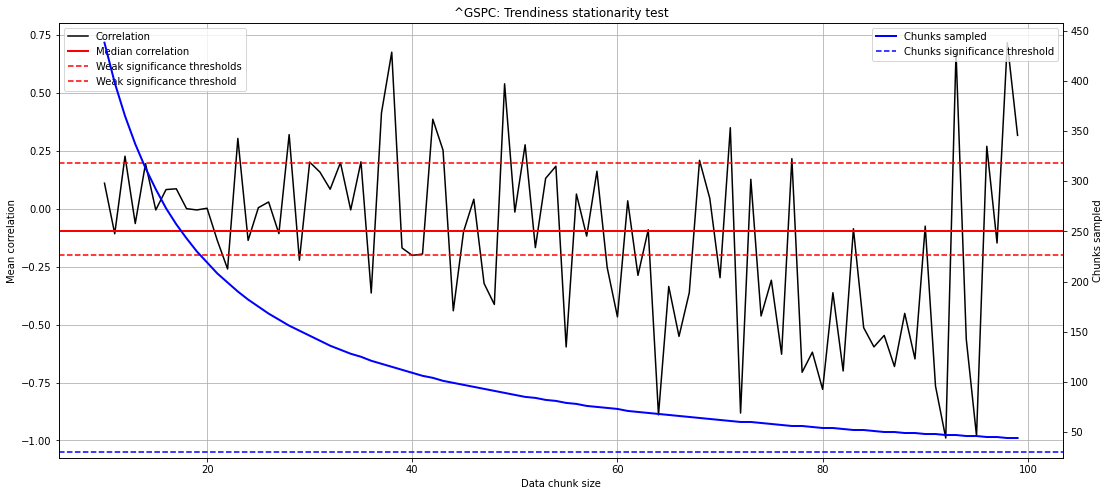

In [6]:
# test a trendiness lambda against a symbol
df = test_stationarity("^GSPC", trendiness_def_1)